# Compressed sensing on images

This notebook intends to illustrate the application of compressed sensing to images.

In particular, given an undersampled image $y$ (on the left), the objective is to reconstruct the original image $x$ (on the right):

![](extra/compressed_sensing.png)

This notebook applies compressed sensing as in [compressed_sensing.ipynb](compressed_sensing.ipynb) but, in this case, to a 2D problem.

Another difference is that in this notebook the basis matrix $\Psi$ is defined as a collection of images defined as a column vectors instead of the Discrete Cosine Transform matrix.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from scipy.sparse import dok_array
import torch
from icecream import ic
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Grayscale
from torchvision.utils import make_grid

from optimize import cosamp

In [2]:
DATA_LABELS = (1, 3, 9)
TARGET_LABEL = DATA_LABELS[2]

## Data

In [3]:
# data
img_size = 128
n_channels = 1
transform = Compose([Resize(img_size), ToTensor(), Grayscale()])
train_dataset = MNIST('data', train=True, transform=transform, download=True)
test_dataset = MNIST('data', train=False, transform=transform, download=True)

## Problem definition

In [4]:
n = img_size * img_size * n_channels
p = n
i = 0
signal_dim = n
undersampled_dim = int(n * 0.1)  # measure 10%
dictionary_size = 2048

## Signal
$x$

In [5]:
# sample image
i = 0
while True:
    test_image, target = test_dataset[i]
    if target == TARGET_LABEL:
        break
    i += 1

Text(0.5, 1.0, 'original image')

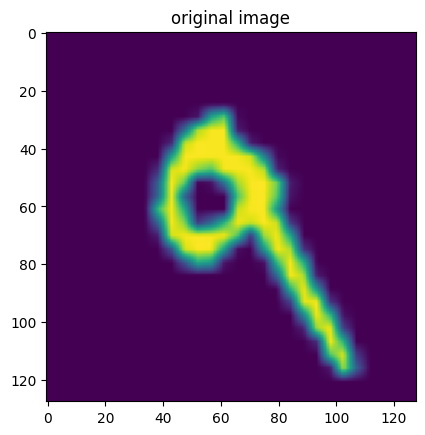

In [6]:
plt.imshow(test_image.permute(1, 2, 0))
plt.title('original image')

In [7]:
x = test_image.view(-1).numpy()

## Sample matrix
$C$

ic| np.count_nonzero(C): 1638


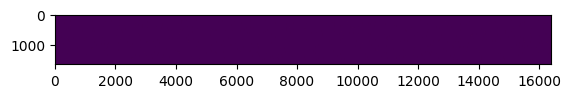

In [8]:
def sample_matrix(undersampled_dim, signal_dim):
    return np.eye(signal_dim)[np.random.randint(signal_dim, size=undersampled_dim)]

C = sample_matrix(undersampled_dim, signal_dim)
ic(np.count_nonzero(C))
plt.imshow(C)

## Undersampled signal
$y = C x$

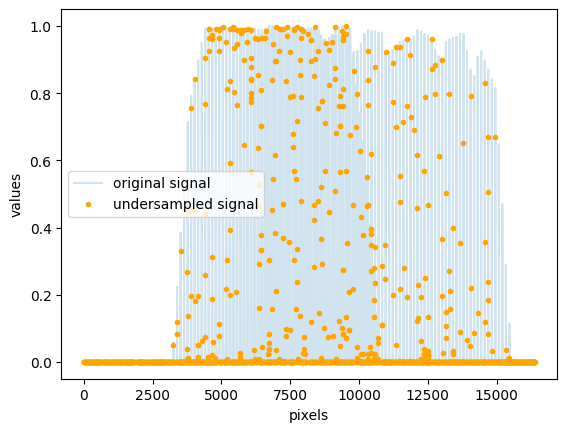

In [9]:
y = C @ x
_coord = C @ np.arange(n)
plt.plot(x, alpha=0.2, label='original signal')
plt.plot(_coord, y, '.', c='orange', label='undersampled signal')
plt.xlabel('pixels')
plt.ylabel('values')
plt.legend()

Text(0.5, 1.0, 'undersampled image')

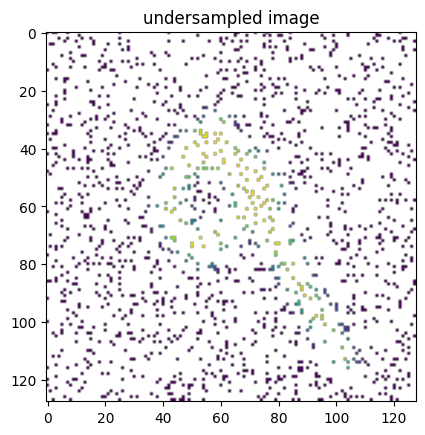

In [10]:
# sampling mask
ii, jj = np.meshgrid(np.arange(img_size), np.arange(img_size), indexing='ij')
ii = C @ ii.flatten()
jj = C @ jj.flatten()
mask = dok_array((img_size, img_size), dtype=bool)
mask[ii, jj] = True

# plot
subsampled_image = ma.masked_array(
    x.reshape(img_size, img_size),
    mask=~mask.todense()
)
plt.imshow(subsampled_image)
plt.title('undersampled image')

## The problem
As mentioned at the beggining, given an undersampled image $y$ (on the left), the objective is to reconstruct the original image $x$ (on the right):

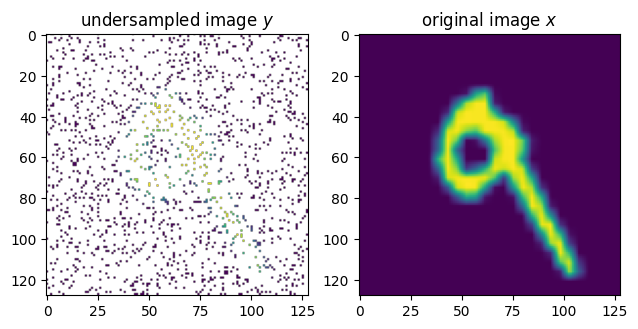

In [11]:
_, (ax1, ax2) = plt.subplots(ncols=2)

ax1.imshow(subsampled_image)
ax1.set_title('undersampled image $y$')
ax2.imshow(test_image.permute(1, 2, 0))
ax2.set_title('original image $x$')
plt.tight_layout()

## Dictionary
$\Psi$

In [12]:
#  dictionary images
dictionary_images = []
indices = []
i = 0
while len(dictionary_images) < dictionary_size:
    image, target = train_dataset[i]
    if target in DATA_LABELS:
        dictionary_images.append(image)
        indices.append(i)
    i += 1

ic| grid.shape: torch.Size([3, 1302, 1302])


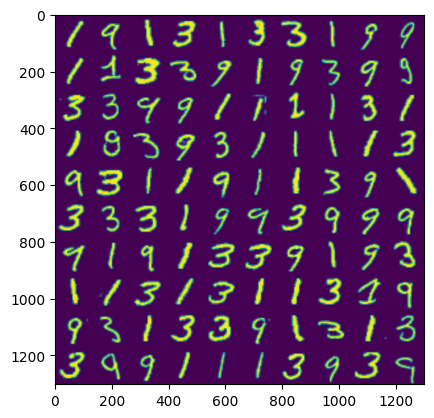

In [13]:
# preview
grid = make_grid(dictionary_images[:100], nrow=10)
ic(grid.shape)
plt.imshow(grid[0], cmap='viridis')
plt.show()

In [14]:
Psi = torch.stack(dictionary_images, dim=-1).view(n_channels * img_size * img_size, -1).numpy()
ic(Psi.shape)

ic| Psi.shape: (16384, 2048)


(16384, 2048)

Text(0, 0.5, 'pixels')

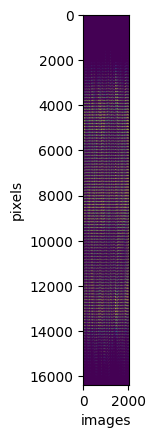

In [15]:
plt.imshow(Psi)
plt.xlabel('images')
plt.ylabel('pixels')

## Theta

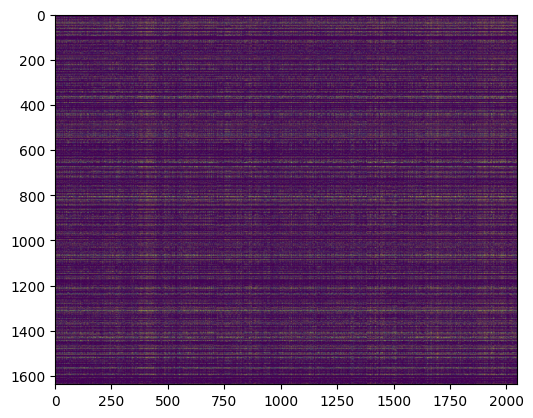

In [16]:
Theta = C @ Psi
plt.imshow(Theta)

## Find sparse representation $s$ of $y$

Find $s$ by solving:

$min ||s||_1$ s.t. $y = \Theta s$

In [17]:
# optimize
sparsity = 3  # number of sparse elements in solution
s = cosamp(Theta, y, sparsity, max_iter=10000)
ic(s)

ic| f'Max. iterations reached: {max_iter}.': 'Max. iterations reached: 10000.'
ic| s: array([0., 0., 0., ..., 0., 0., 0.], shape=(2048,))


array([0., 0., 0., ..., 0., 0., 0.], shape=(2048,))

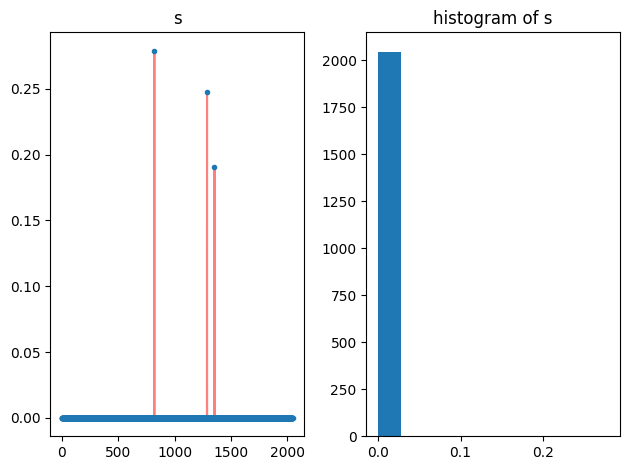

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)

ax1.plot(s, 'red', alpha=.5)
ax1.plot(s, '.')
ax1.set_title('s')
ax2.hist(s)
ax2.set_title('histogram of s')
plt.tight_layout()

### Check $s$ quality

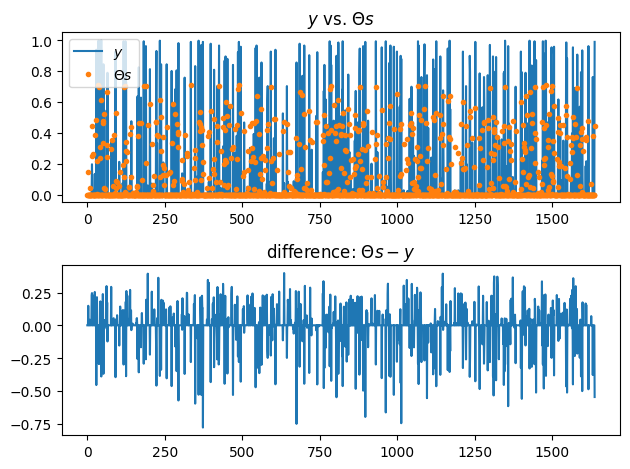

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.plot(y, label='$y$')
ax1.plot(Theta @ s, '.', label='$\Theta s$')
ax1.set_title('$y$ vs. $\Theta s$')
ax1.legend()

ax2.plot(Theta @ s - y)
ax2.set_title('difference: $\Theta s - y$')
plt.tight_layout()

## Recover $x$

This is done by computing $x = \Psi s$ using the obtained sparse vector $s$.

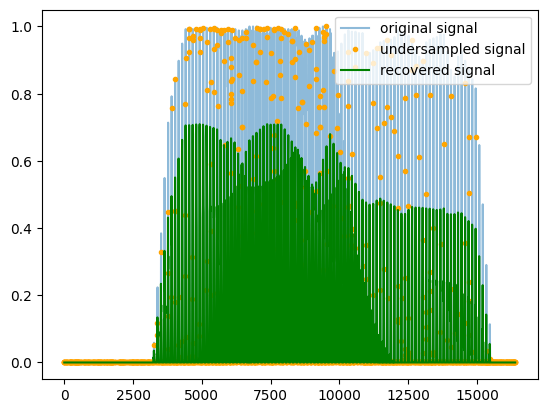

In [20]:
x_r = Psi @ s
_coord = C @ np.arange(n)
plt.plot(x, alpha=0.5, label='original signal')
plt.plot(_coord, y, '.', c='orange', label='undersampled signal')
plt.plot(x_r, c='green', label='recovered signal')
plt.legend()

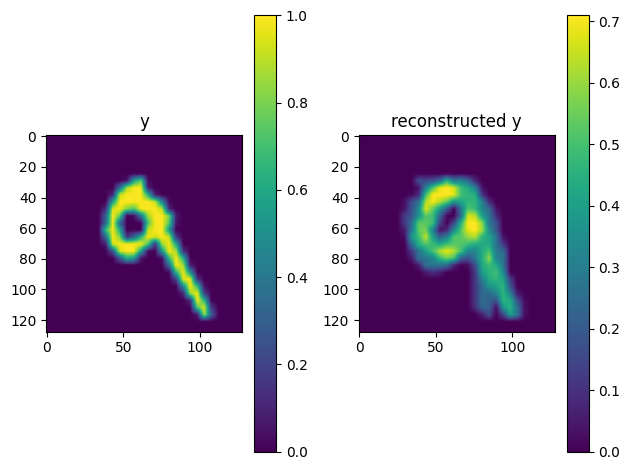

In [21]:
_x = x.reshape(img_size, img_size)
_x_r = x_r.reshape(img_size, img_size)

fig, (ax1, ax2) = plt.subplots(ncols=2)

img = ax1.imshow(_x)
ax1.set_title('y')
fig.colorbar(img)

img = ax2.imshow(_x_r)
ax2.set_title('reconstructed y')
fig.colorbar(img)

plt.tight_layout()

ic| _idx: tensor([ 820, 1288, 1354])
ic| grid.shape: torch.Size([3, 392, 132])


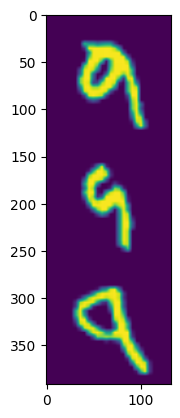

In [22]:
_, _idx = torch.topk(torch.tensor(np.abs(s)), sparsity)
ic(_idx)
grid = make_grid([torch.tensor(Psi[:, i].reshape(img_size, img_size)).unsqueeze(0) for i in _idx], nrow=sparsity // 2)
ic(grid.shape)
plt.imshow(grid[0], cmap='viridis')
plt.show()